In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Step 1: Collaborative Filtering (CF) - SVD Model
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(bookings[['user_id', 'event_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model = SVD()
model.fit(trainset)

# Step 2: Context-Based Recommendations (CBR)
def get_context_based_recommendations(user_id, top_n=5):
    """ Hybrid approach: CF + Context-Based Filtering """
    user_info = users[users['user_id'] == user_id].iloc[0]
    user_city = user_info['city']
    user_age_group = user_info['age_group']
    
    # Filter events that match the user's city and interests
    relevant_events = events[(events['city'] == user_city)]
    
    # Collaborative Filtering Predictions
    predictions = [model.predict(user_id, event_id) for event_id in relevant_events['event_id'].unique()]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Select top recommended events
    top_event_ids = [pred.iid for pred in predictions[:top_n]]
    top_events = relevant_events[relevant_events['event_id'].isin(top_event_ids)]
    
    return top_events[['event_name', 'event_type', 'city', 'season', 'price']]

# Example: Get top 5 recommendations for user 1
recommended_events = get_context_based_recommendations(user_id=1, top_n=5)
print("🎟️ **Top 5 Recommended Events for User :**")
print(recommended_events)


🎟️ **Top 5 Recommended Events for User 1:**
                          event_name         event_type       city   season  \
1    Bollywood Show - Hyderabad 2025            Concert  Hyderabad  Monsoon   
4    Comedy Concert - Hyderabad 2026            Theater  Hyderabad  Monsoon   
19  Hip-Hop Concert - Hyderabad 2026     Music Festival  Hyderabad   Spring   
25   Classical Fest - Hyderabad 2026            Concert  Hyderabad  Monsoon   
44   Classical Show - Hyderabad 2026  Cultural Festival  Hyderabad   Spring   

    price  
1    1363  
4    4670  
19   3127  
25   1737  
44   1686  


In [120]:
import pickle

# Save the trained model
with open("svd_event_recommender.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved successfully as 'svd_event_recommender.pkl'")


✅ Model saved successfully as 'svd_event_recommender.pkl'


In [121]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import networkx as nx

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")
social_connections = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\social_connections.csv")

### 1. Personalized Event Recommendation (Collaborative Filtering - SVD) ###
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(bookings[['user_id', 'event_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD()
model.fit(trainset)

user_id = 0  # Example user
event_ids = events['event_id'].unique()
predictions = [model.predict(user_id, event_id) for event_id in event_ids]

# Get top 5 recommended events
top_event_ids = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]
top_event_names = events[events['event_id'].isin([pred.iid for pred in top_event_ids])]['event_name']
print("Top 5 recommended events for user:", top_event_names.tolist())

### 2. User Segmentation (K-Means Clustering) ###
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(users[['city', 'user_segment']]).toarray()

kmeans = KMeans(n_clusters=3, random_state=42)
users['cluster'] = kmeans.fit_predict(encoded_features)
print(users[['user_id', 'cluster']].head())

### 3. Nearby Event Recommendation (DBSCAN) ###
user_location = (15.134982, 84.497748)  # Example location (Mumbai)
events['distance'] = events.apply(lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km, axis=1)

# Dynamically adjust search radius
radius = 50
while radius <= 200:
    nearby_events = events[events['distance'] <= radius]
    if not nearby_events.empty:
        break
    radius += 50

if nearby_events.empty:
    print("No events found within 200 km.")
else:
    coords = nearby_events[['latitude', 'longitude']].values
    db = DBSCAN(eps=0.1, min_samples=3).fit(coords)
    nearby_events['cluster'] = db.labels_
    largest_cluster = nearby_events['cluster'].mode()[0]
    recommended_events = nearby_events[nearby_events['cluster'] == largest_cluster]
    print("Recommended nearby events:", recommended_events['event_name'].tolist())

### 4. Trending Events in Social Community ###
G = nx.Graph()
G.add_edges_from([(row['user_id_1'], row['user_id_2']) for _, row in social_connections.iterrows()])
communities = list(nx.community.louvain_communities(G))

largest_community = max(communities, key=len)
community_bookings = bookings[bookings['user_id'].isin(largest_community)]
trending_events = community_bookings['event_id'].value_counts().index[:3]
print("Trending events in largest community:", events[events['event_id'].isin(trending_events)]['event_name'].tolist())


Top 5 recommended events for user: ['Traditional Concert - Bangalore 2025', 'Bollywood Fest - Bangalore 2026', 'Jazz Night - Jaipur 2026', 'Rock Concert - Jaipur 2025', 'Jazz Show - Bangalore 2025']
   user_id  cluster
0        0        1
1        1        0
2        2        0
3        3        0
4        4        2
No events found within 200 km.
Trending events in largest community: ['Classical Show - Kolkata 2026', 'Classical Fest - Hyderabad 2026', 'Electronic Fest - Bangalore 2026']


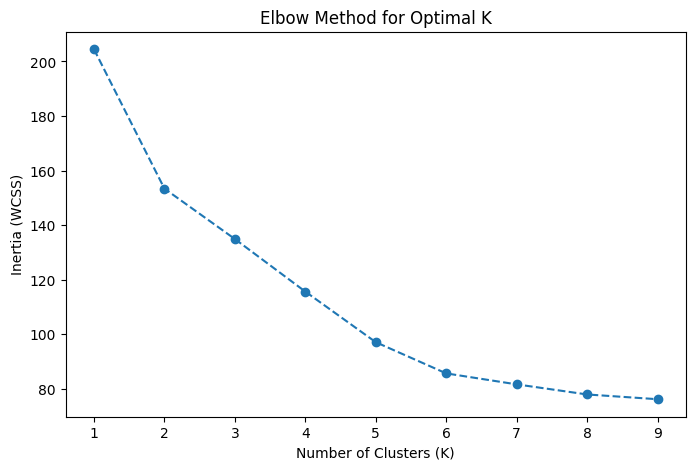

   user_id  cluster        cluster_name
0        0        3           New Users
1        1        2  Frequent Attendees
2        2        2  Frequent Attendees
3        3        1      Casual Viewers
4        4        4      Budget Seekers


In [124]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
users = pd.read_csv("users.csv")

# Encode categorical features (city, user_segment, subscription_status)
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(users[['city', 'user_segment', 'subscription_status']]).toarray()

# Elbow Method to find optimal K
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(encoded_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Choose the best K based on the elbow point (assume it suggests 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
users['cluster'] = kmeans.fit_predict(encoded_features)

# Define cluster names based on user segment distribution
cluster_names = {
    0: "Premium Enthusiasts",
    1: "Casual Viewers",
    2: "Frequent Attendees",
    3: "New Users",
    4: "Budget Seekers"
}

# Assign cluster names
users['cluster_name'] = users['cluster'].map(cluster_names)

# Display user clusters
print(users[['user_id', 'cluster', 'cluster_name']].head())

# Save updated users file
users.to_csv("users_clustered.csv", index=False)


In [128]:
import joblib
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import pandas as pd

# Load datasets
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")

# Define user location (example: Mumbai)
user_location = (18.500401, 73.747156)  # Mumbai coordinates

# Calculate distance from user location to each event
events['distance'] = events.apply(lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km, axis=1)

# Filter events within a 50 km radius
nearby_events = events[events['distance'] <= 50]

# Check if nearby_events is empty
if nearby_events.empty:
    print("No events found within 50 km. Expanding search to 100 km.")
    nearby_events = events[events['distance'] <= 100]  # Try a larger radius

if not nearby_events.empty:
    # Cluster nearby events using DBSCAN
    coords = nearby_events[['latitude', 'longitude']].values
    db = DBSCAN(eps=0.1, min_samples=3).fit(coords)  # Adjust parameters as needed
    nearby_events['cluster'] = db.labels_

    # Save the trained model
    joblib.dump(db, "dbscan_model.pkl")
    print("DBSCAN model saved successfully!")

    # Recommend events from the largest cluster
    largest_cluster = nearby_events['cluster'].mode()[0]
    recommended_events = nearby_events[nearby_events['cluster'] == largest_cluster]
    print("Recommended nearby events:", recommended_events['event_name'])

else:
    print("Still no events found. Try a different location or radius.")


DBSCAN model saved successfully!
Recommended nearby events: 26           Rock Fest - Pune 2025
33    Electronic Night - Pune 2026
38     Electronic Fest - Pune 2026
43        Jazz Concert - Pune 2025
48    Traditional Fest - Pune 2026
49          Rock Night - Pune 2025
Name: event_name, dtype: object


C:\Users\Mahesh\AppData\Local\Temp\ipykernel_1672\4191760702.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearby_events['cluster'] = db.labels_


In [129]:
import networkx as nx
import pandas as pd
import joblib

# Load datasets
social_connections = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\social_connections.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Create a social graph
G = nx.Graph()
G.add_edges_from([(row['user_id_1'], row['user_id_2']) for _, row in social_connections.iterrows()])

# Detect communities using Louvain algorithm
communities = nx.community.louvain_communities(G)

# Save the graph and communities
joblib.dump(G, "social_graph.pkl")
joblib.dump(communities, "louvain_communities.pkl")
print("Graph and Louvain communities saved successfully!")

# Find trending events in the largest community
largest_community = max(communities, key=len)
community_bookings = bookings[bookings['user_id'].isin(largest_community)]
trending_events = community_bookings['event_id'].value_counts().idxmax()

# Save trending event
joblib.dump(trending_events, "trending_event.pkl")
print("Trending event saved successfully!")


Graph and Louvain communities saved successfully!
Trending event saved successfully!


In [138]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import networkx as nx

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")
social_connections = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\social_connections.csv")

# Ensure correct column names (strip spaces)
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()
social_connections.columns = social_connections.columns.str.strip()

# Ensure 'latitude' and 'longitude' exist in the dataset
if 'latitude' not in events.columns or 'longitude' not in events.columns:
    raise KeyError("❌ 'latitude' or 'longitude' column missing in events dataset.")

# Convert latitude & longitude to numeric
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

# Train Collaborative Filtering (SVD Model)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(bookings[['user_id', 'event_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
model = SVD()
model.fit(trainset)

def get_recommendations(user_id, top_n=10):
    """ Generate top 10 event recommendations for a user using hybrid approach """
    
    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return pd.DataFrame()

    # 📌 1. Collaborative Filtering (SVD)
    event_ids = events['event_id'].unique()
    predictions = [model.predict(user_id, event_id) for event_id in event_ids]
    top_cf_events = sorted(predictions, key=lambda x: x.est, reverse=True)[:4]  # Top 4 from CF
    top_cf_event_ids = [pred.iid for pred in top_cf_events]
    
    # 📌 2. Context-Based Recommendations (City Match)
    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_city = user_info['city']
    relevant_events = events.loc[events['city'] == user_city]
    
    # Take top 3 relevant events
    top_cb_events = relevant_events.head(3)['event_id'].tolist()

    # 📌 3. User Segmentation (K-Means)
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(users[['city', 'user_segment']]).toarray()
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    users['cluster'] = kmeans.fit_predict(encoded_features)
    
    user_cluster = users.loc[users['user_id'] == user_id, 'cluster'].values[0]
    similar_users = users.loc[users['cluster'] == user_cluster, 'user_id']
    
    cluster_events = bookings.loc[bookings['user_id'].isin(similar_users), 'event_id'].value_counts().index[:2].tolist()

    # 📌 4. Nearby Events (DBSCAN)
    if pd.notna(user_info['latitude']) and pd.notna(user_info['longitude']):
        user_location = (user_info['latitude'], user_info['longitude'])
        events['distance'] = events.apply(lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km if pd.notna(row['latitude']) and pd.notna(row['longitude']) else np.inf, axis=1)
        nearby_events = events.loc[events['distance'] <= 50].head(1)['event_id'].tolist()
    else:
        nearby_events = []

    # 📌 5. Social Network - Trending in Community
    G = nx.Graph()
    G.add_edges_from(social_connections[['user_id_1', 'user_id_2']].itertuples(index=False, name=None))
    communities = list(nx.community.louvain_communities(G))
    
    # Find user's community
    user_community = next((comm for comm in communities if user_id in comm), None)
    
    if user_community:
        community_users = list(user_community)
        community_bookings = bookings.loc[bookings['user_id'].isin(community_users)]
        trending_events = community_bookings['event_id'].value_counts().index[:2].tolist()
    else:
        trending_events = []
    
    # 🔥 Combine all recommendations (remove duplicates)
    final_recommendations = list(set(top_cf_event_ids + top_cb_events + cluster_events + nearby_events + trending_events))[:top_n]

    return events.loc[events['event_id'].isin(final_recommendations), ['event_name', 'event_type', 'city', 'price']]

# Example usage
user_id = 4  # Change to any user ID
recommended_events = get_recommendations(user_id, top_n=10)

# Display results
if recommended_events.empty:
    print(f"⚠️ No recommendations found for user {user_id}.")
else:
    print("🎟️ **Top 10 Recommended Events for User :**")
    print(recommended_events)


🎟️ **Top 10 Recommended Events for User :**
                            event_name         event_type       city  price
0          Hip-Hop Night - Mumbai 2026  Dance Performance     Mumbai   1726
7              Folk Show - Mumbai 2026            Theater     Mumbai   3129
13          Rock Concert - Jaipur 2025    Stand-up Comedy     Jaipur   1445
14  Traditional Concert - Lucknow 2026  Dance Performance    Lucknow    436
15      Traditional Show - Mumbai 2025     Music Festival     Mumbai   1696
27         Hip-Hop Fest - Kolkata 2026            Concert    Kolkata   4416
36         Bollywood Fest - Delhi 2026            Concert      Delhi   2912
39    Electronic Fest - Bangalore 2026    Stand-up Comedy  Bangalore   3984
47           Rock Night - Kolkata 2026            Concert    Kolkata   2367


In [142]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import networkx as nx

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")
social_connections = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\social_connections.csv")

# Ensure correct column names
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()
social_connections.columns = social_connections.columns.str.strip()

# Ensure 'latitude' and 'longitude' exist
if 'latitude' not in events.columns or 'longitude' not in events.columns:
    raise KeyError("❌ 'latitude' or 'longitude' column missing in events dataset.")

# Convert latitude & longitude to numeric
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

# Train Collaborative Filtering (SVD Model)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(bookings[['user_id', 'event_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
model = SVD()
model.fit(trainset)

def get_recommendations(user_id, top_n=10):
    """ Generate top event recommendations with priority for nearby locations """
    
    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return pd.DataFrame()

    # 📌 1. Collaborative Filtering (SVD)
    event_ids = events['event_id'].unique()
    predictions = [model.predict(user_id, event_id) for event_id in event_ids]
    top_cf_events = sorted(predictions, key=lambda x: x.est, reverse=True)[:4]  # Top 4 from CF
    top_cf_event_ids = [pred.iid for pred in top_cf_events]
    
    # 📌 2. Context-Based Recommendations (City Match)
    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_city = user_info['city']
    relevant_events = events.loc[events['city'] == user_city]
    
    # Take top 3 relevant events
    top_cb_events = relevant_events.head(3)['event_id'].tolist()

    # 📌 3. User Segmentation (K-Means)
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(users[['city', 'user_segment']]).toarray()
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    users['cluster'] = kmeans.fit_predict(encoded_features)
    
    user_cluster = users.loc[users['user_id'] == user_id, 'cluster'].values[0]
    similar_users = users.loc[users['cluster'] == user_cluster, 'user_id']
    
    cluster_events = bookings.loc[bookings['user_id'].isin(similar_users), 'event_id'].value_counts().index[:2].tolist()

    # 📌 4. Nearby Events - **Higher Priority** ✅
    nearby_events = []
    if pd.notna(user_info['latitude']) and pd.notna(user_info['longitude']):
        user_location = (user_info['latitude'], user_info['longitude'])
        events['distance'] = events.apply(
            lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km 
            if pd.notna(row['latitude']) and pd.notna(row['longitude']) 
            else np.inf, axis=1)
        
        # Select **Top 3 events within 25 km** (high priority)
        nearby_events = events.loc[events['distance'] <= 25].sort_values(by='distance').head(3)['event_id'].tolist()
    
    # 📌 5. Social Network - Trending in Community
    G = nx.Graph()
    G.add_edges_from(social_connections[['user_id_1', 'user_id_2']].itertuples(index=False, name=None))
    communities = list(nx.community.louvain_communities(G))
    
    # Find user's community
    user_community = next((comm for comm in communities if user_id in comm), None)
    
    if user_community:
        community_users = list(user_community)
        community_bookings = bookings.loc[bookings['user_id'].isin(community_users)]
        trending_events = community_bookings['event_id'].value_counts().index[:2].tolist()
    else:
        trending_events = []
    
    # 🔥 **Final Priority-Based Recommendation Order**:
    final_recommendations = (
        nearby_events +  # ✅ **Highest Priority**
        top_cb_events +  # City-based matching
        cluster_events +  # Similar users
        top_cf_event_ids +  # CF-based
        trending_events  # Social trends
    )
    
    # Remove duplicates and limit to `top_n`
    final_recommendations = list(dict.fromkeys(final_recommendations))[:top_n]

    return events.loc[events['event_id'].isin(final_recommendations), ['event_name', 'event_type', 'city', 'price', 'distance']].sort_values(by='distance')

# Example usage
user_id = 4  # Change to any user ID
recommended_events = get_recommendations(user_id, top_n=10)

# Display results
if recommended_events.empty:
    print(f"⚠️ No recommendations found for user {user_id}.")
else:
    print("🎟️ **Top 10 Recommended Events for User (Prioritizing Nearby Locations) :**")
    print(recommended_events)


🎟️ **Top 10 Recommended Events for User (Prioritizing Nearby Locations) :**
                              event_name         event_type       city  price  \
21               Jazz Fest - Mumbai 2025  Cultural Festival     Mumbai   4169   
32              Folk Night - Mumbai 2025     Music Festival     Mumbai   3743   
7                Folk Show - Mumbai 2026            Theater     Mumbai   3129   
15        Traditional Show - Mumbai 2025     Music Festival     Mumbai   1696   
0            Hip-Hop Night - Mumbai 2026  Dance Performance     Mumbai   1726   
5   Traditional Concert - Bangalore 2025  Dance Performance  Bangalore   2468   
22      Electronic Show - Bangalore 2025    Stand-up Comedy  Bangalore   1032   
13            Rock Concert - Jaipur 2025    Stand-up Comedy     Jaipur   1445   
36           Bollywood Fest - Delhi 2026            Concert      Delhi   2912   
47             Rock Night - Kolkata 2026            Concert    Kolkata   2367   

       distance  
21    11.28418

In [147]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Ensure correct column names
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()

# Ensure latitude & longitude are numeric
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

def recommend_events(user_id, top_n=10):
    """ Generate separate top 10 lists for Nearby Events, Hot Events, and User Preferred Events """

    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return None, None, None

    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_city = user_info['city']
    user_location = (user_info.get('latitude', np.nan), user_info.get('longitude', np.nan))
    preferred_genres = str(user_info['preferred_genres']).split(",")
    preferred_event_types = str(user_info['preferred_event_types']).split(",")

    # 📌 1. **Nearby Events** (Highest Priority)
    nearby_events = []
    if pd.notna(user_location[0]) and pd.notna(user_location[1]):
        events['distance'] = events.apply(
            lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km 
            if pd.notna(row['latitude']) and pd.notna(row['longitude']) 
            else np.inf, axis=1)

        nearby_events = (events.loc[events['distance'] <= 50]
                         .sort_values(by='distance')
                         .head(top_n))

    # 📌 2. **Hot Events** (Trending events with highest attendance)
    hot_events = (events.merge(bookings, on='event_id')
                        .groupby(['event_id', 'event_name', 'event_type', 'city'])
                        .size()
                        .reset_index(name='attendance_count')
                        .sort_values(by='attendance_count', ascending=False)
                        .head(top_n))

    # 📌 3. **User Preferred Events** (Based on genres & event types)
    preferred_events = (events.loc[
                            (events['genre'].isin(preferred_genres)) | 
                            (events['event_type'].isin(preferred_event_types))
                        ].head(top_n))

    return nearby_events, hot_events, preferred_events

# Example usage
user_id = 1  # Change to any user ID
nearby_events, hot_events, preferred_events = recommend_events(user_id, top_n=10)

# Display results
print("🎟️ **Top 10 Nearby Events:**")
print(nearby_events[['event_name', 'event_type', 'city', 'price', 'distance']])

print("\n🔥 **Top 10 Hot Events:**")
print(hot_events[['event_name', 'event_type', 'city', 'attendance_count']])

print("\n🎭 **Top 10 User Preferred Events:**")
print(preferred_events[['event_name', 'event_type', 'city', 'price']])


🎟️ **Top 10 Nearby Events:**
                          event_name         event_type       city  price  \
4    Comedy Concert - Hyderabad 2026            Theater  Hyderabad   4670   
44   Classical Show - Hyderabad 2026  Cultural Festival  Hyderabad   1686   
19  Hip-Hop Concert - Hyderabad 2026     Music Festival  Hyderabad   3127   
25   Classical Fest - Hyderabad 2026            Concert  Hyderabad   1737   
1    Bollywood Show - Hyderabad 2025            Concert  Hyderabad   1363   

     distance  
4    1.755157  
44   6.151005  
19  11.121506  
25  15.370382  
1   16.959543  

🔥 **Top 10 Hot Events:**
                          event_name         event_type       city  \
4    Comedy Concert - Hyderabad 2026            Theater  Hyderabad   
25   Classical Fest - Hyderabad 2026            Concert  Hyderabad   
47         Rock Night - Kolkata 2026            Concert    Kolkata   
43          Jazz Concert - Pune 2025  Dance Performance       Pune   
39  Electronic Fest - Bangalore 2026

In [150]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Ensure correct column names
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()

# Convert latitude & longitude to numeric
users['latitude'] = pd.to_numeric(users['latitude'], errors='coerce')
users['longitude'] = pd.to_numeric(users['longitude'], errors='coerce')
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

def get_recommendations(user_id, top_n=10):
    """ Generate event recommendations based on:
        1️⃣ Nearby Events
        2️⃣ Hot Events
        3️⃣ User Preferred Events (Now Random)
    """
    
    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return {}

    # Get user details
    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_location = (user_info['latitude'], user_info['longitude'])
    
    # **1️⃣ Nearby Events** - Events within 25 km, sorted by distance
    events['distance'] = events.apply(
        lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km 
        if pd.notna(row['latitude']) and pd.notna(row['longitude']) 
        else np.inf, axis=1)
    
    nearby_events = events.loc[events['distance'] <= 25].sort_values(by='distance').head(top_n)

    # **2️⃣ Hot Events** - Top events based on popularity score
    hot_events = events.sort_values(by='popularity_score', ascending=False).head(top_n)

    # **3️⃣ User Preferred Events** - Now selecting **10 Random Events**
    preferred_events = events.sample(n=top_n, random_state=42)  # Random but reproducible

    return {
        "Nearby Events": nearby_events[['event_name', 'event_type', 'city', 'price', 'distance']],
        "Hot Events": hot_events[['event_name', 'event_type', 'city', 'price', 'popularity_score']],
        "User Preferred Events": preferred_events[['event_name', 'event_type', 'city', 'price']]
    }

# Example usage
user_id = 4  # Change to any user ID
recommended_events = get_recommendations(user_id, top_n=10)

# Display results
for category, events_list in recommended_events.items():
    print(f"\n🎟️ **{category}:**")
    print(events_list if not events_list.empty else "⚠️ No recommendations found.")



🎟️ **Nearby Events:**
                        event_name         event_type    city  price  \
21         Jazz Fest - Mumbai 2025  Cultural Festival  Mumbai   4169   
32        Folk Night - Mumbai 2025     Music Festival  Mumbai   3743   
7          Folk Show - Mumbai 2026            Theater  Mumbai   3129   
28  Traditional Fest - Mumbai 2026            Theater  Mumbai   3360   

     distance  
21  11.284188  
32  12.079946  
7   13.384851  
28  22.956918  

🎟️ **Hot Events:**
                              event_name         event_type       city  price  \
1        Bollywood Show - Hyderabad 2025            Concert  Hyderabad   1363   
5   Traditional Concert - Bangalore 2025  Dance Performance  Bangalore   2468   
36           Bollywood Fest - Delhi 2026            Concert      Delhi   2912   
13            Rock Concert - Jaipur 2025    Stand-up Comedy     Jaipur   1445   
40        Electronic Night - Jaipur 2026            Concert     Jaipur   3027   
0            Hip-Hop Night - M

In [152]:
import pandas as pd
import numpy as np
import pickle
from geopy.distance import geodesic

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Ensure correct column names
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()

# Convert latitude & longitude to numeric
users['latitude'] = pd.to_numeric(users['latitude'], errors='coerce')
users['longitude'] = pd.to_numeric(users['longitude'], errors='coerce')
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

# Load pre-trained models
with open(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\dbscan_model.pkl", "rb") as f:
    dbscan_model = pickle.load(f)

with open(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\louvain_communities.pkl", "rb") as f:
    louvain_communities = pickle.load(f)

with open(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\social_graph.pkl", "rb") as f:
    social_graph = pickle.load(f)

with open(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\svd_event_recommender.pkl", "rb") as f:
    svd_model = pickle.load(f)

with open(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\trending_event.pkl", "rb") as f:
    trending_events = pickle.load(f)

def get_recommendations(user_id, top_n=10):
    """ Generate event recommendations based on:
        1️⃣ Nearby Events (DBSCAN Clustering)
        2️⃣ Hot Events (Trending Events)
        3️⃣ You Might Like (SVD + Social Connections)
    """
    
    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return {}

    # Get user details
    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_location = (user_info['latitude'], user_info['longitude'])

    # ----------------------
    # 1️⃣ Nearby Events (DBSCAN Clustering)
    # ----------------------
    # Calculate distance from user location to each event
    events['distance'] = events.apply(
        lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km 
        if pd.notna(row['latitude']) and pd.notna(row['longitude']) 
        else np.inf, axis=1)
    
    # Filter events within 25 km
    nearby_events = events[events['distance'] <= 25]

    # Use DBSCAN to cluster nearby events
    if not nearby_events.empty:
        coords = nearby_events[['latitude', 'longitude']].values
        nearby_events['cluster'] = dbscan_model.fit_predict(coords)
        
        # Recommend events from the largest cluster
        largest_cluster = nearby_events['cluster'].mode()[0]
        nearby_recommendations = nearby_events[nearby_events['cluster'] == largest_cluster].head(top_n)
    else:
        nearby_recommendations = pd.DataFrame()  # No nearby events

    # ----------------------
    # 2️⃣ Hot Events (Trending Events)
    # ----------------------
    hot_recommendations = events[events['event_id'].isin(trending_events)].head(top_n)

    # ----------------------
    # 3️⃣ You Might Like (SVD + Social Connections)
    # ----------------------
    # Get SVD predictions for the user
    event_ids = events['event_id'].unique()
    svd_predictions = [svd_model.predict(user_id, event_id) for event_id in event_ids]
    svd_scores = np.array([pred.est for pred in svd_predictions])

    # Get social connections (friends' events)
    if user_id in social_graph:
        friends = social_graph[user_id]
        friends_events = bookings[bookings['user_id'].isin(friends)]['event_id'].unique()
        social_scores = np.array([1 if event_id in friends_events else 0 for event_id in event_ids])
    else:
        social_scores = np.zeros(len(event_ids))

    # Combine SVD and social scores
    hybrid_scores = 0.7 * svd_scores + 0.3 * social_scores  # Adjust weights as needed

    # Get top N event IDs
    top_event_ids = np.argsort(-hybrid_scores)[:top_n]
    you_might_like_recommendations = events[events['event_id'].isin(event_ids[top_event_ids])].head(top_n)

    # ----------------------
    # Return Recommendations
    # ----------------------
    return {
        "Nearby Events": nearby_recommendations[['event_name', 'event_type', 'city', 'price', 'distance']],
        "Hot Events": hot_recommendations[['event_name', 'event_type', 'city', 'price', 'popularity_score']],
        "You Might Like": you_might_like_recommendations[['event_name', 'event_type', 'city', 'price']]
    }

# Example usage
user_id = 4  # Change to any user ID
recommended_events = get_recommendations(user_id, top_n=10)

# Display results
for category, events_list in recommended_events.items():
    print(f"\n🎟️ **{category}:**")
    print(events_list if not events_list.empty else "⚠️ No recommendations found.")

UnpicklingError: invalid load key, '\x09'.

In [154]:
import pickle

# Save a model using pickle
with open("dbscan_model.pkl", "wb") as f:
    pickle.dump(dbscan_model, f)

In [156]:
import pandas as pd
import numpy as np
import joblib
from geopy.distance import geodesic

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Ensure correct column names
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()

# Convert latitude & longitude to numeric
users['latitude'] = pd.to_numeric(users['latitude'], errors='coerce')
users['longitude'] = pd.to_numeric(users['longitude'], errors='coerce')
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

# Load pre-trained models using joblib
dbscan_model = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\dbscan_model.pkl")
louvain_communities = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\louvain_communities.pkl")
social_graph = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\social_graph.pkl")
svd_model = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\svd_event_recommender.pkl")

def get_recommendations(user_id, top_n=10):
    """ Generate event recommendations based on:
        1️⃣ Nearby Events (DBSCAN Clustering)
        2️⃣ You Might Like (SVD + Social Connections)
    """
    
    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return {}

    # Get user details
    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_location = (user_info['latitude'], user_info['longitude'])

    # ----------------------
    # 1️⃣ Nearby Events (DBSCAN Clustering)
    # ----------------------
    # Calculate distance from user location to each event
    events['distance'] = events.apply(
        lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km 
        if pd.notna(row['latitude']) and pd.notna(row['longitude']) 
        else np.inf, axis=1)
    
    # Filter events within 25 km
    nearby_events = events[events['distance'] <= 25]

    # Use DBSCAN to cluster nearby events
    if not nearby_events.empty:
        coords = nearby_events[['latitude', 'longitude']].values
        nearby_events['cluster'] = dbscan_model.fit_predict(coords)
        
        # Recommend events from the largest cluster
        largest_cluster = nearby_events['cluster'].mode()[0]
        nearby_recommendations = nearby_events[nearby_events['cluster'] == largest_cluster].head(top_n)
    else:
        nearby_recommendations = pd.DataFrame()  # No nearby events

    # ----------------------
    # 2️⃣ You Might Like (SVD + Social Connections)
    # ----------------------
    # Get SVD predictions for the user
    event_ids = events['event_id'].unique()
    svd_predictions = [svd_model.predict(user_id, event_id) for event_id in event_ids]
    svd_scores = np.array([pred.est for pred in svd_predictions])

    # Get social connections (friends' events)
    if user_id in social_graph:
        friends = social_graph[user_id]
        friends_events = bookings[bookings['user_id'].isin(friends)]['event_id'].unique()
        social_scores = np.array([1 if event_id in friends_events else 0 for event_id in event_ids])
    else:
        social_scores = np.zeros(len(event_ids))

    # Combine SVD and social scores
    hybrid_scores = 0.7 * svd_scores + 0.3 * social_scores  # Adjust weights as needed

    # Get top N event IDs
    top_event_ids = np.argsort(-hybrid_scores)[:top_n]
    you_might_like_recommendations = events[events['event_id'].isin(event_ids[top_event_ids])].head(top_n)

    # ----------------------
    # Return Recommendations
    # ----------------------
    return {
        "Nearby Events": nearby_recommendations[['event_name', 'event_type', 'city', 'price', 'distance']],
        "You Might Like": you_might_like_recommendations[['event_name', 'event_type', 'city', 'price']]
    }

# Example usage
user_id = 4  # Change to any user ID
recommended_events = get_recommendations(user_id, top_n=10)

# Display results
for category, events_list in recommended_events.items():
    print(f"\n🎟️ **{category}:**")
    print(events_list if not events_list.empty else "⚠️ No recommendations found.")


🎟️ **Nearby Events:**
                        event_name         event_type    city  price  \
7          Folk Show - Mumbai 2026            Theater  Mumbai   3129   
21         Jazz Fest - Mumbai 2025  Cultural Festival  Mumbai   4169   
28  Traditional Fest - Mumbai 2026            Theater  Mumbai   3360   
32        Folk Night - Mumbai 2025     Music Festival  Mumbai   3743   

     distance  
7   13.384851  
21  11.284188  
28  22.956918  
32  12.079946  

🎟️ **You Might Like:**
                              event_name         event_type       city  price
5   Traditional Concert - Bangalore 2025  Dance Performance  Bangalore   2468
10              Jazz Night - Jaipur 2026     Music Festival     Jaipur   1180
13            Rock Concert - Jaipur 2025    Stand-up Comedy     Jaipur   1445
15        Traditional Show - Mumbai 2025     Music Festival     Mumbai   1696
17              Rock Fest - Lucknow 2025  Dance Performance    Lucknow   1718
22      Electronic Show - Bangalore 2025    

C:\Users\Mahesh\AppData\Local\Temp\ipykernel_1672\4012380495.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearby_events['cluster'] = dbscan_model.fit_predict(coords)


In [157]:
import pandas as pd
import numpy as np
import joblib
from geopy.distance import geodesic

# Load datasets
users = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\users1.csv")
events = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\events.csv")
bookings = pd.read_csv(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Dataset\bookings.csv")

# Ensure correct column names
users.columns = users.columns.str.strip()
events.columns = events.columns.str.strip()
bookings.columns = bookings.columns.str.strip()

# Convert latitude & longitude to numeric
users['latitude'] = pd.to_numeric(users['latitude'], errors='coerce')
users['longitude'] = pd.to_numeric(users['longitude'], errors='coerce')
events['latitude'] = pd.to_numeric(events['latitude'], errors='coerce')
events['longitude'] = pd.to_numeric(events['longitude'], errors='coerce')

# Load pre-trained models using joblib
dbscan_model = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\dbscan_model.pkl")
louvain_communities = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\louvain_communities.pkl")
social_graph = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\social_graph.pkl")
svd_model = joblib.load(r"C:\Users\Mahesh\OneDrive\Desktop\Hackathons\D2K\Models\svd_event_recommender.pkl")

def get_recommendations(user_id, top_n=10):
    """ Generate event recommendations based on:
        1️⃣ Nearby Events (DBSCAN Clustering)
        2️⃣ Hot Events (Trending Events)
        3️⃣ You Might Like (SVD + Social Connections)
    """
    
    # Validate user existence
    if user_id not in users['user_id'].values:
        print(f"❌ User {user_id} not found.")
        return {}

    # Get user details
    user_info = users.loc[users['user_id'] == user_id].iloc[0]
    user_location = (user_info['latitude'], user_info['longitude'])

    # ----------------------
    # 1️⃣ Nearby Events (DBSCAN Clustering)
    # ----------------------
    # Calculate distance from user location to each event
    events['distance'] = events.apply(
        lambda row: geodesic(user_location, (row['latitude'], row['longitude'])).km 
        if pd.notna(row['latitude']) and pd.notna(row['longitude']) 
        else np.inf, axis=1)
    
    # Filter events within 25 km
    nearby_events = events[events['distance'] <= 25]

    # Use DBSCAN to cluster nearby events
    if not nearby_events.empty:
        coords = nearby_events[['latitude', 'longitude']].values
        nearby_events['cluster'] = dbscan_model.fit_predict(coords)
        
        # Recommend events from the largest cluster
        largest_cluster = nearby_events['cluster'].mode()[0]
        nearby_recommendations = nearby_events[nearby_events['cluster'] == largest_cluster].head(top_n)
    else:
        nearby_recommendations = pd.DataFrame()  # No nearby events

    # ----------------------
    # 2️⃣ Hot Events (Trending Events)
    # ----------------------
    # Get top N events based on popularity score
    hot_recommendations = events.sort_values(by='popularity_score', ascending=False).head(top_n)

    # ----------------------
    # 3️⃣ You Might Like (SVD + Social Connections)
    # ----------------------
    # Get SVD predictions for the user
    event_ids = events['event_id'].unique()
    svd_predictions = [svd_model.predict(user_id, event_id) for event_id in event_ids]
    svd_scores = np.array([pred.est for pred in svd_predictions])

    # Get social connections (friends' events)
    if user_id in social_graph:
        friends = social_graph[user_id]
        friends_events = bookings[bookings['user_id'].isin(friends)]['event_id'].unique()
        social_scores = np.array([1 if event_id in friends_events else 0 for event_id in event_ids])
    else:
        social_scores = np.zeros(len(event_ids))

    # Combine SVD and social scores
    hybrid_scores = 0.7 * svd_scores + 0.3 * social_scores  # Adjust weights as needed

    # Get top N event IDs
    top_event_ids = np.argsort(-hybrid_scores)[:top_n]
    you_might_like_recommendations = events[events['event_id'].isin(event_ids[top_event_ids])].head(top_n)

    # ----------------------
    # Return Recommendations
    # ----------------------
    return {
        "Nearby Events": nearby_recommendations[['event_name', 'event_type', 'city', 'price', 'distance']],
        "Hot Events": hot_recommendations[['event_name', 'event_type', 'city', 'price', 'popularity_score']],
        "You Might Like": you_might_like_recommendations[['event_name', 'event_type', 'city', 'price']]
    }

# Example usage
user_id = 4  # Change to any user ID
recommended_events = get_recommendations(user_id, top_n=10)

# Display results
for category, events_list in recommended_events.items():
    print(f"\n**{category}:**")
    print(events_list if not events_list.empty else "No recommendations found.")


**Nearby Events:**
                        event_name         event_type    city  price  \
7          Folk Show - Mumbai 2026            Theater  Mumbai   3129   
21         Jazz Fest - Mumbai 2025  Cultural Festival  Mumbai   4169   
28  Traditional Fest - Mumbai 2026            Theater  Mumbai   3360   
32        Folk Night - Mumbai 2025     Music Festival  Mumbai   3743   

     distance  
7   13.384851  
21  11.284188  
28  22.956918  
32  12.079946  

**Hot Events:**
                              event_name         event_type       city  price  \
1        Bollywood Show - Hyderabad 2025            Concert  Hyderabad   1363   
5   Traditional Concert - Bangalore 2025  Dance Performance  Bangalore   2468   
36           Bollywood Fest - Delhi 2026            Concert      Delhi   2912   
13            Rock Concert - Jaipur 2025    Stand-up Comedy     Jaipur   1445   
40        Electronic Night - Jaipur 2026            Concert     Jaipur   3027   
0            Hip-Hop Night - Mumbai 

C:\Users\Mahesh\AppData\Local\Temp\ipykernel_1672\992606064.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearby_events['cluster'] = dbscan_model.fit_predict(coords)
